The code calculates the compressible flow inside a converging-diverging nozzle with circular cross-section.

The hypotheses are:
- steady state
- adiabatic nozzle
- no work through boundaries
- no friction losses
- ideal gas model

The geometry of the nozzle is determined by specifying the following:
- Cross-section area of inlet, throat and outlet
- Axial position of inlet, throat and outlet
The nozzle geometry is described with a 5th order polynomial that enforces:
- Areas at inlet, throat and outlet are equal to the ones specified by the user
- Gradient of diameter x axial position curve is null at inlet, at throat and at outlet
- Other ways of specifying the area can be implemented. The information to the code must be an array with the coordinates of axial position and diameter.

The code is able to compute the following cases: 
- A: Venturi Regime 
- B: 1st critical, isentropic flow 
- C: Supersonic throat, shockwave at diffuser 
- D: 2nd critical, shockwave at outlet 
- E: Supersonic throat, overexpansion outside nozzle 
- F: 3rd critical, isentropic flow 
- G: Supersonic flow downstream throat, shockwave outside nozzle <br>

The algorithm computes the sonic throat and the three critical solutions downstream the throat: 
- p2_sub   => 1st critical: subsonic 
- p2_2nd   => 2nd critical: supersonic with shockwave at outlet 
- p2_super => 3rd critical: supersonic without shockwave at outlet  <br>

The outlet pressure (p2) is compared to the pressures of the critical solutions

For the cases where a shockwave is present, the position of the shock is determined with an iterative algorithm based on a bisection method:<br>
- 1) The solution of the flow from inlet to sonic throat is calculated with isentropic relations.<br>
- 2) An initial guess of a shockwave a bit downstream the throat is considered and an initial step (dx=x_next-x_current) is defined.<br>
- 3) The flow properties between throat and immediately upstream the shock are computed with isentropic relations.<br>
- 4) The flow properties immediately downstream the shock are computed with shockwave relations for ideal gases.<br>
- 5) The flow properties between the shock and outlet are computed with isentropic relations.<br>
- 6) The calculated pressure at outlet is compared to the specied pressure at outlet.<br>
- 7) If the sign of the error of the current iteration is equal to the sign of the error at the previous iteration, there is no solution between iterations. The step is kept unchanged: dx_next=dx_current.<br>
- 8) Otherwise, there is a solution between two iterations. The step dx is updated to be dx_next=-dx_current/2.<br>
- 9) The next guess for the position of the shockwave is updated: x_next=x_current+dx.<br>
- 10) Go back to step (3) and iterate until a desired convergence is achieved.<br>


In [35]:
import numpy as np
import matplotlib.pyplot as plt


class Quasi_1D_Nozzle():
    def __init__(self):
        ''' '''
        self.Properties()
        self.Geometry()
        self.OperationalConditions()
        
    def main(self):

        self.name="p0="+'{:.0f}'.format(self.p0)+"_T0="+'{:.0f}'.format(self.T0)+"_p2="+'{:.0f}'.format(self.p2)
        self.IsentropicOutletPressures()
        self.OperationalRegime()
        self.CalculateNozzle()

    def Properties(self):
        ''' Ideal gas model properties:
                gamma
                R
            '''
        self.gamma=1.4 # Specific heat ratio
        self.R=287 # Constant of ideal gas - air [J/kg*K]

    def Geometry(self):
        ''' Indices for geometry:
                0) Stagnation
                1) Inlet
                t) Throat section
                2)Outlet section
                '''
        # Parameters
        self.A1=1.0*10**-2 # Cross section area at inlet [m²]
        self.d1=(4*self.A1/np.pi)**(1/2) # Diameter [m]
        self.x1=0.0 # Axial position of inlet [m]

        self.At=0.5*10**-2 # Cross section area at throat [m²]
        self.dt=(4*self.At/np.pi)**(1/2) # Diameter [m]
        self.xt=0.5 # Axial position of throat [m]
        
        self.A2=0.7*10**-2 # Cross section area at outlet [m²]
        self.d2=(4*self.A2/np.pi)**(1/2) # Diameter [m]
        self.x2=1.0 # Axial position of outlet [m]

        self.PolynomialFitting()

##        plt.plot(self.x_vector,self.d_vector)
##        plt.plot(self.x1,self.d1,marker='o', label='inlet')
##        plt.plot(self.xt,self.dt,marker='o', label='throat')
##        plt.plot(self.x2,self.d2,marker='o', label='outlet')
##        plt.xlim([self.x1,self.x2])
##        plt.ylim([0,max(self.d1,self.d2)])
##        plt.xlabel("x coordinate [m]")
##        plt.ylabel("nozzle diameter [m]")
##        plt.title("Nozzle geometry")
##        plt.legend()
##        plt.show()

    def OperationalConditions(self):

        # Stagnation
        self.p0=1.5*10**5 # Pressure [Pa]
        self.T0=300 # Temperature [K]

        # Outlet
        self.p2=1.45*10**5 # Pressure [Pa]

    def PolynomialFitting(self):
        ''' Diameter along x is a 5th order polynomial:
                f(x)=a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5
            The coefficients are obtained solving the linear system of equations:
                f(x1)=d1
                f'(x1)=imposed, zero by default
                f(xt)=dt
                f'(xt)=zero
                f(x2)=d2
                f'(x2)=imposed, zero by default
                '''
        x1=self.x1 # x coordinate of points
        xt=self.xt
        x2=self.x2

        d1=self.d1 # diameters
        dt=self.dt
        d2=self.d2

        dd1=np.arctan(0) # slope at inlet
        dd2=np.arctan(1*np.pi/180) # slope at outlet

        npts=200 # number of points for discretization
        
        
        X=np.array([[1,x1,x1**2,x1**3,x1**4,x1**5],
                   [0,1,2*x1,3*x1**2,4*x1**3,5*x1**4],
                   [1,xt,xt**2,xt**3,xt**4,xt**5],
                   [0,1,2*xt,3*xt**2,4*xt**3,5*xt**4],
                   [1,x2,x2**2,x2**3,x2**4,x2**5],
                   [0,1,2*x2,3*x2**2,4*x2**3,5*x2**4]])
        b=np.array([d1,dd1,dt,0,d2,dd2])
        a=np.linalg.solve(X, b)
        
        a0=a[0]
        a1=a[1]
        a2=a[2]
        a3=a[3]
        a4=a[4]
        a5=a[5]
        
        self.x_vector=np.linspace(x1,x2,npts)
        
        self.d_vector=a0+a1*self.x_vector+a2*self.x_vector**2+a3*self.x_vector**3+a4*self.x_vector**4+a5*self.x_vector**5
        self.A_vector=np.pi*self.d_vector**2/4

        
    def CalculateNozzle(self):
        '''Cases:
                A: Venturi Regime
                B: 1st critical, isentropic flow
                C: Supersonic throat, shockwave at diffuser
                D: 2nd critical, shockwave at outlet
                E: Supersonic throat, overexpansion outside nozzle
                F: 3rd critical, isentropic flow
                G: Supersonic flow downstream throat, shockwave outside nozzle
        '''
        if self.regime=="A" or self.regime=="B":
            self.ds=0 # change in entropy

            # Outlet section
            self.M2=(2/(self.gamma-1)*((self.p0/self.p2)**((self.gamma-1)/(self.gamma))-1))**(1/2)
            M_vector=0*np.ones(len(self.A_vector))
            for i in range(0,len(self.A_vector)):
                M_vector[i]=self.ComputeIsentropicMach(self.A2,self.M2,self.A_vector[i],"sub")
            self.M_vector=M_vector
            self.p_vector=self.p0/(1+(self.gamma-1)/2*self.M_vector**2)**(self.gamma/(self.gamma-1))
            

        elif self.regime=="D" or self.regime=="E" or self.regime=="F" or self.regime=="G":
            # Sonic throat
            self.Mt_s=1 # Sonic throat
            self.pt_s=self.p0*((1+((self.gamma-1)/2*(0**2))/(1+((self.gamma-1)/2*(self.Mt_s**2))))) # Isentropic acceleration from stagnation to sonic throat
            
            # Solution
            M_vector=0*np.ones(len(self.A_vector))
            for i in range(0,len(self.A_vector)):
                if self.x_vector[i]<=self.xt: # Inlet to throat
                    M_vector[i]=self.ComputeIsentropicMach(self.At,self.Mt_s,self.A_vector[i],"sub")
                else: # Throat to outlet
                    M_vector[i]=self.ComputeIsentropicMach(self.At,self.Mt_s,self.A_vector[i],"super")
            self.M_vector=M_vector
            self.p_vector=self.p0/(1+(self.gamma-1)/2*self.M_vector**2)**(self.gamma/(self.gamma-1))

        elif self.regime=="C":
            # Sonic throat
            self.Mt_s=1 # Sonic throat
            self.pt_s=self.p0*((1+((self.gamma-1)/2*(0**2))/(1+((self.gamma-1)/2*(self.Mt_s**2))))) # Isentropic acceleration from stagnation to sonic throat
            
            # Solution
            M_vector=0*np.ones(len(self.A_vector))
            p_vector=0*np.ones(len(self.A_vector))
            self.CalculateShockwavePosition()
            
            for i in range(0,len(self.A_vector)):
                if self.x_vector[i]<=self.xt: # Inlet to throat
                    M_vector[i]=self.ComputeIsentropicMach(self.At,self.Mt_s,self.A_vector[i],"sub")
                    p_vector[i]=self.p0/(1+(self.gamma-1)/2*M_vector[i]**2)**(self.gamma/(self.gamma-1))
                elif self.x_vector[i]>self.xt and self.x_vector[i]<=self.x_shock:
                    #M_vector[i]=self.ComputeIsentropicMach(self.At,self.Mt_s,self.A_vector[i],"super")
                    M_vector[i]=self.ComputeIsentropicMach(self.A_shock,self.M_shock_A,self.A_vector[i],"super")
                    p_vector[i]=self.p0/(1+(self.gamma-1)/2*M_vector[i]**2)**(self.gamma/(self.gamma-1))
                else:
                    M_vector[i]=self.ComputeIsentropicMach(self.A_shock,self.M_shock_B,self.A_vector[i],"sub")
                    p_vector[i]=self.p0_shock_B/(1+(self.gamma-1)/2*M_vector[i]**2)**(self.gamma/(self.gamma-1))
            self.M_vector=M_vector
            self.p_vector=p_vector
            
        fig, axs = plt.subplots(3,1, sharex=True, sharey=False)
        plt.suptitle("Nozzle geometry and pressure distribution\nCase:"+self.name)
        axs[0].set_ylabel("Diameter [m]")
        axs[0].plot(self.x_vector,self.d_vector,color="b",label="Geometry")
        #axs[0].legend(loc=0)
        axs[0].set_ylim([0,max(self.d1,self.d2)])
        axs[1].set_ylabel("Mach number [-]")
        axs[1].plot(self.x_vector,self.M_vector,color="b",label="Mach number")
        axs[1].set_ylim([0,max(self.M_vector)])
        #axs[1].legend(loc=2)
        axs[2].set_ylabel("Pressure [Pa]")
        axs[2].plot(self.x_vector,self.p_vector,color="b",label="Pressure")
        axs[2].set_ylim([min(self.p_vector),max(self.p_vector)])
        #axs[2].legend(loc=2)
        
        plt.xlim([self.x1,self.x2])
        plt.xlabel("x coordinate [m]")
        
        #plt.legend()
        #plt.show()
        plt.savefig('Nozzle'+"_"+self.name)
            
    def CalculateShockwavePosition(self):
        print("Compute Shockwave Position")
        x_shock_new=self.xt+0.005*(self.x2-self.xt) # initial guess for the shockwave position
        p2_new, error_new, M_shock_A, M_shock_B, A_shock = self.CalculateDownstreamShock(x_shock_new)
        
        x_shock_old=x_shock_new
        p2_old=p2_new
        error_old=error_new

        dx=0.005*(self.x2-self.xt)
        tol=0.1 # Desired tolerance
        i=0 # Initial iteration
        i_max=400 # Maximum number of iterations

        while abs(error_new)>tol and i<i_max:
            x_shock_new=x_shock_new+dx
            p2_new, error_new, M_shock_A, M_shock_B, A_shock = self.CalculateDownstreamShock(x_shock_new)
            if error_new*error_old<0:
                dx=-dx/2
            error_old=error_new
            i=i+1
            if i%20==0:
                print("iter = "+str(i)+"| x_shock = "+'{:.10f}'.format(x_shock_new)+" | p2_new = "+'{:.0f}'.format(p2_new)+" | p2 = "+'{:.0f}'.format(self.p2)+"| error = "+'{:.1f}'.format(error_new))
        print("iter = "+str(i)+"| x_shock = "+'{:.10f}'.format(x_shock_new)+" | p2_new = "+'{:.0f}'.format(p2_new)+" | p2 = "+'{:.0f}'.format(self.p2)+"| error = "+'{:.1f}'.format(error_new))
        print("")

        if abs(error_new)<tol and i<=i_max: # If solution is converged
            self.x_shock=x_shock_new
            self.A_shock=A_shock
            self.M_shock_A=M_shock_A
            self.M_shock_B=M_shock_B
        else: # If solution is not converged
            print("M2s_new didn't converge")
        

    def CalculateDownstreamShock(self,x_shock):
        A_shock=self.Interpolate(self.x_vector,self.A_vector,x_shock)
        M_shock_A=self.ComputeIsentropicMach(self.At,self.Mt_s,A_shock,"super")
        p0_shock_A=self.p0
        M_shock_B=((M_shock_A**2+2/(self.gamma-1))/(2*self.gamma/(self.gamma-1)*M_shock_A**2-1))**(1/2)
        p0_shock_B=p0_shock_A*(((self.gamma+1)/2*M_shock_A**2)/(1+(self.gamma-1)/2*M_shock_A**2))**(self.gamma/(self.gamma-1))*(2*self.gamma/(self.gamma+1)*M_shock_A**2-(self.gamma-1)/(self.gamma+1))**(1/(1-self.gamma))
        M2=self.ComputeIsentropicMach(A_shock,M_shock_B,self.A2,"sub")
        p0_2=p0_shock_B
        #print("p0_shock_A = "+str(p0_shock_A)+"| p0_shock_B = "+str(p0_shock_B))
        p2=p0_2/((1+(self.gamma-1)/2*M2**2)**(self.gamma/(self.gamma-1)))
        error=self.p2-p2
        self.p0_shock_B=p0_shock_B

        

        return p2, error, M_shock_A, M_shock_B, A_shock

    def Interpolate(self,X,Y,x):
        for i in range(0,len(X)-1):
            #print("x = "+str(x)+"| X[i] = "+str(X[i])+"| X[i+1] = "+str(X[i+1]))
            if x>X[i] and x<=X[i+1]:
                y=Y[i]+(Y[i+1]-Y[i])/(X[i+1]-X[i])*(x-X[i])
        return y
            
    def IsentropicOutletPressures(self):
        ''' The algorithm computes the sonic throat and the two isentropic solutions downstream the throat:
                1st critical: subsonic
                3rd critical: supersonic
        '''
        # Sonic throat
        self.Mt_s=1 # Sonic throat
        self.pt_s=self.p0/(1+((self.gamma-1)/2*(self.Mt_s**2))) # Isentropic acceleration from stagnation to sonic throat
        
        # 1st critical - Isentropic subsonic solution
        self.M2s_sub=self.ComputeIsentropicMach(self.At,self.Mt_s,self.A2,"sub")
        self.p2s_sub=self.p0/(1+((self.gamma-1)/2)*self.M2s_sub**2)**(self.gamma/(self.gamma-1))

        # 3rd critical - Isentropic supersonic solution
        self.M2s_super=self.ComputeIsentropicMach(self.At,self.Mt_s,self.A2,"super")
        self.p2s_super=self.p0/((1+((self.gamma-1)/2)*self.M2s_super**2)**(self.gamma/(self.gamma-1)))

        # 2nd critical - Shockwave at oulet
        self.M2_2nd=((self.M2s_super**2+2/(self.gamma-1))/(2*self.gamma/(self.gamma-1)*self.M2s_super**2-1))**(1/2)
        self.p2_2nd=self.p2s_super*(1+self.gamma*self.M2s_super**2)/(1+self.gamma*self.M2_2nd**2)
        #self.p2_2nd=self.p2s_super
        

    def OperationalRegime(self):
        ''' Function that determines the type of compressible regime inside the nozzle:
                A: Venturi Regime
                B: 1st critical, isentropic flow
                C: Supersonic throat, shockwave at diffuser
                D: 2nd critical, shockwave at outlet
                E: Supersonic throat, overexpansion outside nozzle
                F: 3rd critical, isentropic flow
                G: Supersonic flow downstream throat, shockwave outside nozzle
                
            The algorithm computes the sonic throat and the three critical solutions downstream the throat:
                p2_sub   => 1st critical: subsonic
                p2_2nd   => 2nd critical: supersonic with shockwave at outlet
                p2_super => 3rd critical: supersonic without shockwave at outlet
            The outlet pressure (p2) is compared to the pressures of the critical solutions'''
        print("")
        print("p2 = "+'{:.0f}'.format(self.p2)+"| p2s_sub = "+'{:.0f}'.format(self.p2s_sub)+"| p2_2nd = "+'{:.0f}'.format(self.p2_2nd)+"| p2s_super = "+'{:.0f}'.format(self.p2s_super))
        # Verification
        if self.p2>self.p2s_sub:
            print("Regime: Venturi Regime")
            self.regime="A"
        elif self.p2==self.p2s_sub:
            print("Regime: 1st critical, isentropic flow")
            self.regime="B"
        elif self.p2<self.p2s_sub and self.p2>self.p2_2nd:
            print("Regime: Supersonic throat, shockwave at diffuser")
            self.regime="C"
        elif self.p2==self.p2_2nd:
            print("Regime: 2nd critical, isentropic flow")
            self.regime="D"
        elif self.p2<self.p2_2nd and self.p2>self.p2s_super:
            print("Regime: Supersonic throat, overexpansion downstream diffuser")
            self.regime="E"
        elif self.p2==self.p2s_super:
            print("Regime: 3rd critical, isentropic flow")
            self.regime="F"
        elif self.p2<self.p2s_super:
            print("Regime: Supersonic flow downstream throat, shockwave outside nozzle")
            self.regime="G"
        # Curve Mach versus Area at Nozzle outlet
        M2s_vector,A2s_vector=self.CurvesMachVersusArea()
##        plt.plot(M2s_vector,A2s_vector)
##        plt.plot(self.M2s_sub,self.A2,marker='o', label='sub')
##        plt.plot(self.M2s_super,self.A2,marker='o', label='super')
##        plt.xlabel("Mach number at outlet")
##        plt.ylabel("Area at outlet [m]")
##        plt.title("Relation between Mach number and outlet area for isentropic flow")
##        plt.legend()
##        plt.show()
        
        
    def CurvesMachVersusArea(self):
        M2s_vector=np.linspace(0.1,3,50)
        At_vector=self.At*np.ones(len(M2s_vector))
        Mt_s_vector=self.Mt_s*np.ones(len(M2s_vector))
        A2s_vector=At_vector*Mt_s_vector/M2s_vector*((1+((self.gamma-1)/2*M2s_vector**2))/(1+((self.gamma-1)/2*Mt_s_vector**2)))**((self.gamma+1)/(2*(self.gamma-1)))
        return M2s_vector,A2s_vector


    def ComputeIsentropicMach(self,A1,M1,A2,case):
        M2s_new=1 # New value of Mach number
        M2s_old=1 # Old value of Mach number
        A2s=A1*M1/M2s_new*((1+((self.gamma-1)/2*M2s_new**2))/(1+((self.gamma-1)/2*M1**2)))**((self.gamma+1)/(2*(self.gamma-1))) # Outlet area calculated with new Mach number
        error_new=A2-A2s # New value of error
        error_old=A2-A2s # Old value of error
        if case=="sub":
            dM=-0.1 # Number of Mach will decrease to subsonic levels with respect to initial guess
        elif case=="super":
            dM=+0.1 # Number of Mach will increase to supersonic levels with respect to initial guess
        tol=1*10**-8 # Desired tolerance
        i=0 # Initial iteration
        i_max=100 # Maximum number of iterations

        while abs(error_new)>tol and i<i_max:
            M2s_new=M2s_new+dM # Updating new Mach number
            A2s=A1*M1/M2s_new*((1+((self.gamma-1)/2*M2s_new**2))/(1+((self.gamma-1)/2*M1**2)))**((self.gamma+1)/(2*(self.gamma-1))) # Recalculating A2s
            error_new=A2-A2s # Recalculating error
            if error_new*error_old<0: # Comparing with last error
                dM=-1/2*dM # Bisection rule
            M2s_old=M2s_new # Updating old Mach number
            error_old=error_new # Updating old error
            i=i+1 # Updating iteration
            #print("iter = "+str(i)+"| M2s = "+'{:.4f}'.format(M2s_new)+" | A2s = "+'{:.4f}'.format(A2s)+"| A2 = "+'{:.4f}'.format(A2)+"| error = "+'{:.5f}'.format(error_new))
        
        if abs(error_new)<tol and i<=100: # If solution is converged
            return M2s_new
        else: # If solution is not converged
            print("M2s_new didn't converge")
        


p2 = 145000| p2s_sub = 128871| p2_2nd = 95553| p2s_super = 27613
Regime: Venturi Regime

p2 = 135000| p2s_sub = 128871| p2_2nd = 95553| p2s_super = 27613
Regime: Venturi Regime

p2 = 130000| p2s_sub = 128871| p2_2nd = 95553| p2s_super = 27613
Regime: Venturi Regime

p2 = 128800| p2s_sub = 128871| p2_2nd = 95553| p2s_super = 27613
Regime: Supersonic throat, shockwave at diffuser
Compute Shockwave Position
iter = 20| x_shock = 0.5300000000 | p2_new = 128800 | p2 = 128800| error = 0.2
iter = 21| x_shock = 0.5299804687 | p2_new = 128800 | p2 = 128800| error = -0.1


p2 = 120000| p2s_sub = 128871| p2_2nd = 95553| p2s_super = 27613
Regime: Supersonic throat, shockwave at diffuser
Compute Shockwave Position
iter = 20| x_shock = 0.5525000000 | p2_new = 128528 | p2 = 120000| error = -8528.3
iter = 40| x_shock = 0.6025000000 | p2_new = 126840 | p2 = 120000| error = -6840.3
iter = 60| x_shock = 0.6525000000 | p2_new = 123585 | p2 = 120000| error = -3585.1
iter = 80| x_shock = 0.6931250000 | p2_n

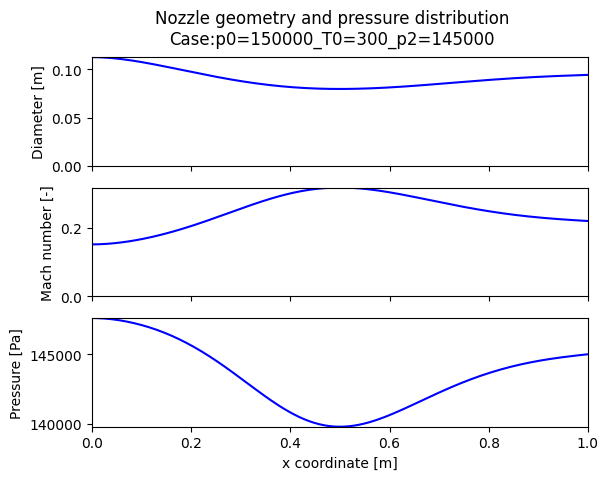

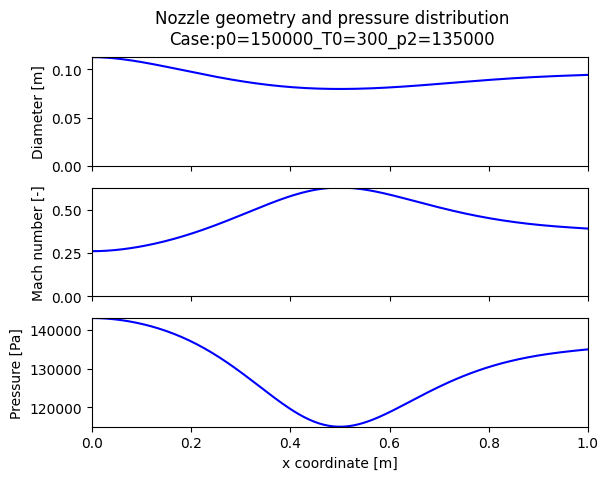

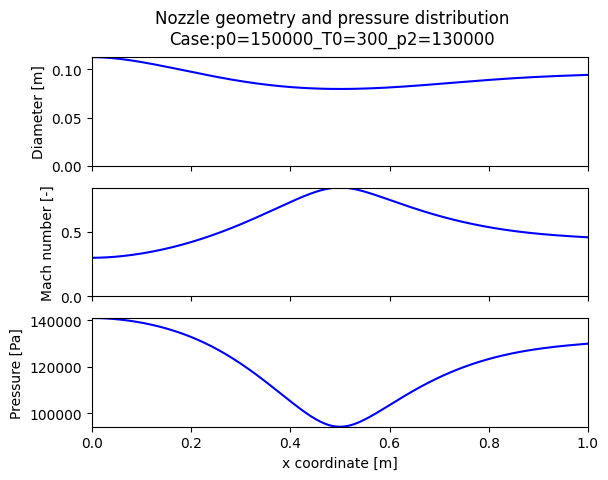

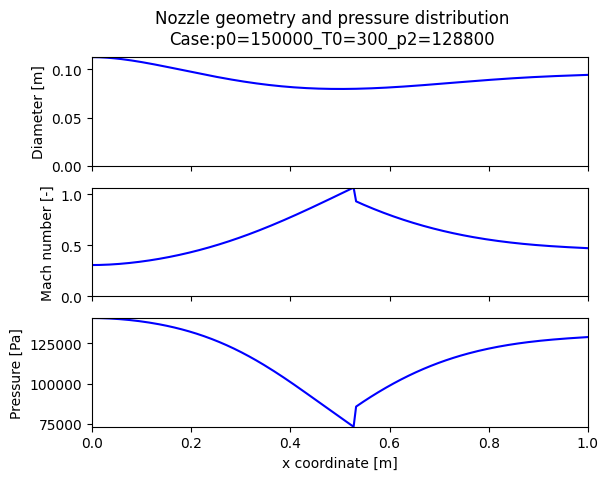

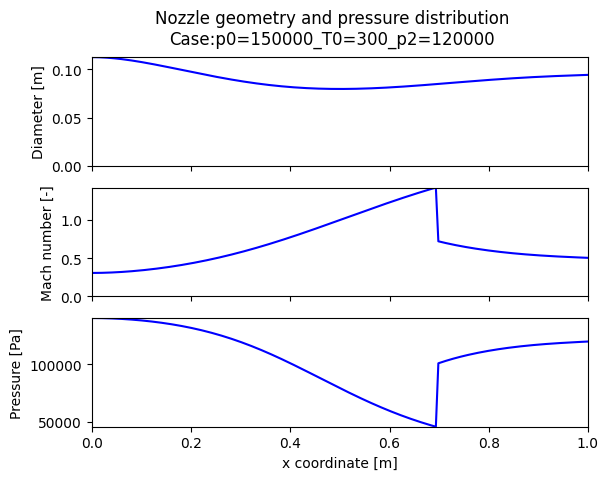

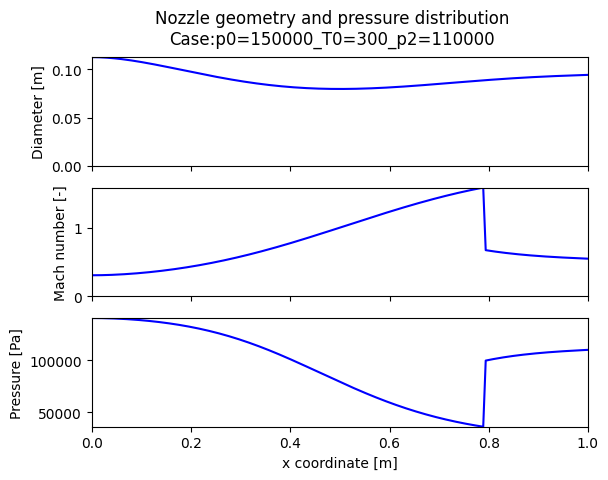

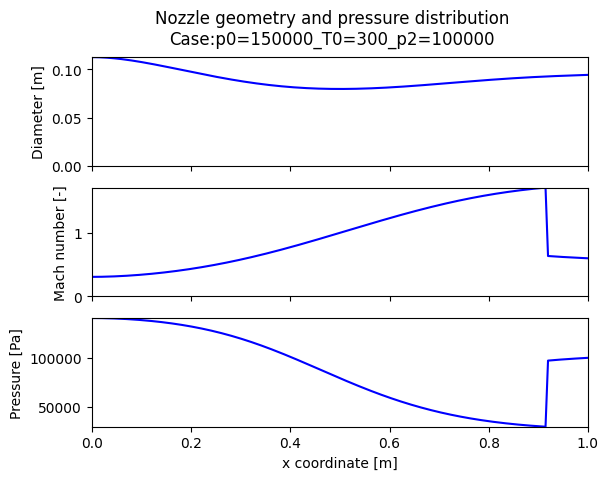

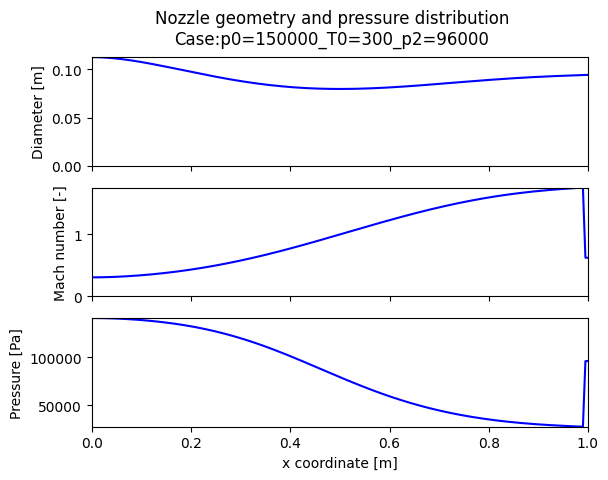

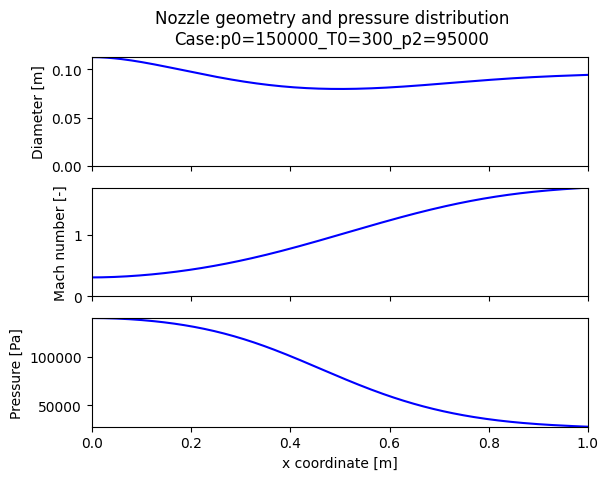

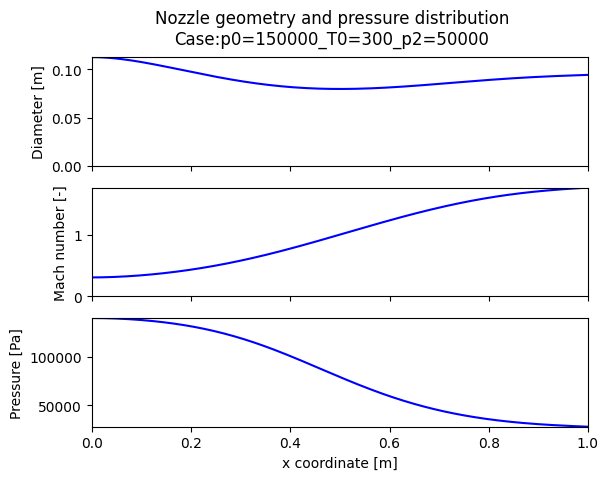

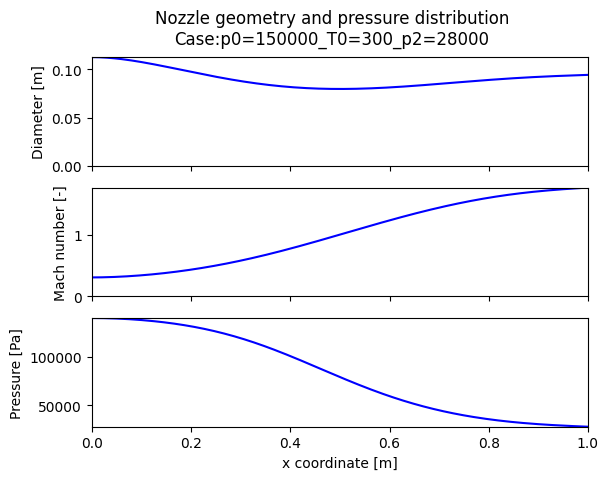

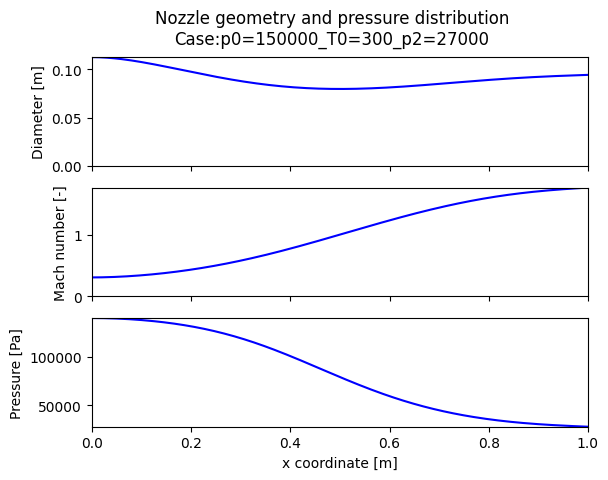

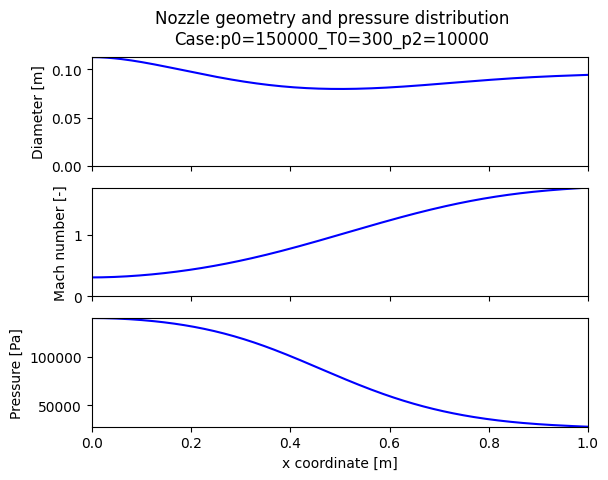

In [36]:
teste=Quasi_1D_Nozzle()
p2_array=[1.45,1.35,1.3,1.288,1.2,1.1,1.0,0.96,0.95,0.5,0.28,0.27,0.1]
for p2 in p2_array:
    teste.p2=p2*10**5 # Pressure [Pa]
    teste.main()